In [2]:
import pandas as pd
import numpy as np
np.random.seed(2)

import collections

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#from sklearn.metrics import confusion_matrix

from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing import image

import os
from PIL import Image

**Import labels and images to arrays**

In [3]:
labels = pd.read_csv('./SMILE_Dataset/annotations.csv', header=None, names=['fname','label'])
# Shuffle data
labels = labels.sample(frac=1).reset_index()

x = np.array([image.img_to_array(image.load_img('./SMILE_Dataset/all/'+fname, target_size=(128, 128))) for fname in labels['fname']])

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels['label'])
y = integer_encoded

**Create train and validation set**

In [13]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state = 10)

In [14]:
# My models are having time using this split of data. Therefore, part of my error analysis will be investigating why!
# And not use kfold because it takes too long

X_train = np.concatenate((x[0:120], x[160::]), axis = 0)
y_train = np.concatenate((y[0:120], y[160::]), axis = 0)

X_test = x[120:160]
y_test = y[120:160]

In [21]:
model = build_model()

datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=10, # randomly rotate images in the range (degrees, 0 to 180)
                             width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1, 
                             shear_range=0.1,
                             zoom_range=0.1)   

datagen.fit(X_train)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                        patience=4, 
                                        verbose=1, 
                                        factor=0.5, 
                                        min_lr=0.00001)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 32), epochs = 3, 
                          validation_data = (X_test,y_test), steps_per_epoch=len(X_train) / 32,
                          callbacks=[learning_rate_reduction])




Epoch 1/3
12/11 [================================] - 9s 713ms/step - loss: 1.6013 - acc: 0.5083 - val_loss: 0.3218 - val_acc: 0.9500
Epoch 2/3
12/11 [================================] - 8s 676ms/step - loss: 0.6653 - acc: 0.6167 - val_loss: 188.6373 - val_acc: 0.4750
Epoch 3/3
12/11 [================================] - 8s 664ms/step - loss: 0.6240 - acc: 0.6833 - val_loss: 20.7970 - val_acc: 0.7250


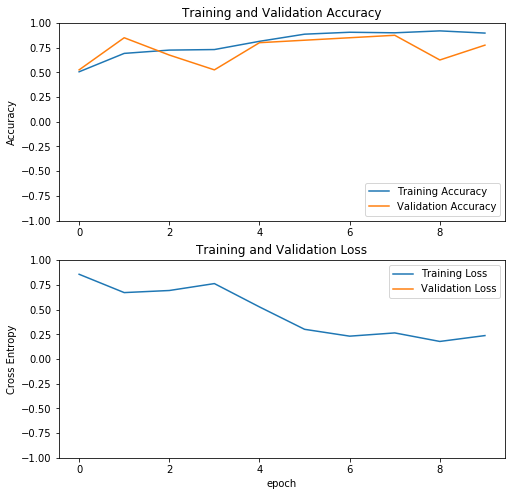

In [168]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([-1,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [151]:
acc

[0.50555557,
 0.69166666,
 0.725,
 0.73055553,
 0.8138889,
 0.88611114,
 0.90555555,
 0.9,
 0.91944444,
 0.8972222]

# Models

In [20]:
model = models.Sequential()
# model.add(layers.Conv2D(32, (5,5),padding = 'Same', activation ='relu', input_shape=(64, 64, 3)))
# model.add(layers.Conv2D(32, (5,5),padding = 'Same', activation ='relu'))
# model.add(layers.MaxPool2D(pool_size=(2,2)))
# model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

prior = models.load_model('model_test.h5')
for layer in prior.layers[0].layers[2:]:
    model.add(layer)

ValueError: Cannot create group in read-only mode.

In [ ]:
def build_trans_model1():

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    prior = load_model('model_test.h5')


In [170]:
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
def build_model4():
    dropout_dense_layer = 0.1

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_dense_layer))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_dense_layer))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])
    return model

In [ ]:
def build_model3():
    
    model = models.Sequential()

    model.add(layers.Conv2D(32, (5,5),padding = 'Same', activation ='relu', input_shape=(64, 64, 3)))
    model.add(layers.Conv2D(32, (5,5),padding = 'Same', activation ='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.25))


    model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
              metrics=['acc'])
    return model

In [6]:
def build_model2():
    
    model = models.Sequential()

    model.add(layers.Conv2D(32, (5,5),padding = 'Same', activation ='relu', input_shape=(128, 128, 3)))
    model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(32, (3,3),padding = 'Same', activation ='relu'))
    model.add(layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
              metrics=['acc'])
    return model

In [11]:
def build_model():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Feed to a densily connected layer for prediction
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
              metrics=['acc'])
    
    return model

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=10,
                                  width_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
datagen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [28]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 32), epochs = 50, 
                              validation_data = (X_val,y_val), steps_per_epoch=len(X_train) / 32,
                              callbacks=[learning_rate_reduction])

Epoch 1/20
12/11 [================================] - 2s 161ms/step - loss: 0.0776 - acc: 0.9694 - val_loss: 9.2421 - val_acc: 0.9500
Epoch 2/20
12/11 [================================] - 2s 156ms/step - loss: 0.0808 - acc: 0.9722 - val_loss: 9.1715 - val_acc: 0.9500
Epoch 3/20
12/11 [================================] - 2s 154ms/step - loss: 0.0772 - acc: 0.9750 - val_loss: 9.1436 - val_acc: 0.9500
Epoch 4/20
12/11 [================================] - 2s 159ms/step - loss: 0.0770 - acc: 0.9778 - val_loss: 9.0988 - val_acc: 0.9500
Epoch 5/20
12/11 [================================] - 2s 162ms/step - loss: 0.0764 - acc: 0.9750 - val_loss: 9.0718 - val_acc: 0.9500
Epoch 6/20
12/11 [================================] - 2s 163ms/step - loss: 0.1075 - acc: 0.9722 - val_loss: 8.9662 - val_acc: 0.9500
Epoch 7/20
12/11 [================================] - 2s 162ms/step - loss: 0.0776 - acc: 0.9722 - val_loss: 8.8984 - val_acc: 0.9500
Epoch 8/20
12/11 [================================] - 2s 154ms

In [30]:
y_pred = model.predict(X_val)

In [23]:
asarray()

AttributeError: 'numpy.ndarray' object has no attribute 'asarray'

In [33]:
from sklearn.metrics import classification_report
?classification_report

In [35]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.95      0.95      0.95        21

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



# K FOLD!

In [129]:
reports = []

kf = StratifiedKFold(n_splits=10)

# shuffle data
id = 1
for train_index, test_index in kf.split(x,y):
    print('Kfold iteration {}/10'.format(id))
    id += 1
    print('Total images: {} ---- Train images: {} ---- Test images: {}'.format(len(x),len(train_index),len(test_index)))
    #print("Train index start:{} and finish index: {}".format(train_index[0],train_index[-1]))
    print("Test index start:{} and finish index: {}".format(test_index[0],test_index[-1]))
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print('Distribution of labels: {}'.format(collections.Counter(y_test)))
    
    model = build_model2()

    datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=10, # randomly rotate images in the range (degrees, 0 to 180)
                                 width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
                                 height_shift_range=0.1, 
                                 shear_range=0.1,
                                 zoom_range=0.1)   
    
    datagen.fit(X_train)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
    
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 20), epochs = 30, 
                              validation_data = (X_test,y_test), steps_per_epoch=len(X_train) / 32,
                              callbacks=[learning_rate_reduction])
    
    y_pred = model.predict(X_test)
    y_pred = [np.round(p[0]) for p in y_pred]
    
    print(classification_report(y_test, y_pred))
    reports.append(classification_report(y_test, y_pred,output_dict=True))

Kfold iteration 1/10
Total images: 400 ---- Train images: 360 ---- Test images: 40
Test index start:0 and finish index: 46
Distribution of labels: Counter({0: 20, 1: 20})
Epoch 1/30
12/11 [================================] - 10s 860ms/step - loss: 1.5807 - acc: 0.5250 - val_loss: 6.2337 - val_acc: 0.5000
Epoch 2/30
12/11 [================================] - 9s 781ms/step - loss: 0.6816 - acc: 0.6000 - val_loss: 60.3931 - val_acc: 0.5000
Epoch 3/30
12/11 [================================] - 10s 823ms/step - loss: 0.6665 - acc: 0.6167 - val_loss: 3.2481 - val_acc: 0.8250
Epoch 4/30
12/11 [================================] - 9s 786ms/step - loss: 0.6897 - acc: 0.7556 - val_loss: 22.2777 - val_acc: 0.6500
Epoch 5/30
12/11 [================================] - 9s 784ms/step - loss: 0.4665 - acc: 0.7667 - val_loss: 355.9328 - val_acc: 0.5000
Epoch 6/30
12/11 [================================] - 10s 794ms/step - loss: 0.7325 - acc: 0.6528 - val_loss: 31.6437 - val_acc: 0.7500

Epoch 00006: Red

12/11 [================================] - 10s 797ms/step - loss: 0.1567 - acc: 0.9528 - val_loss: 0.5418 - val_acc: 0.9750
Epoch 21/30
12/11 [================================] - 10s 825ms/step - loss: 0.1308 - acc: 0.9556 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 22/30
12/11 [================================] - 10s 794ms/step - loss: 0.1536 - acc: 0.9417 - val_loss: 0.0000e+00 - val_acc: 1.0000

Epoch 00022: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 23/30
12/11 [================================] - 10s 799ms/step - loss: 0.1165 - acc: 0.9556 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 24/30
12/11 [================================] - 10s 801ms/step - loss: 0.1039 - acc: 0.9583 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 25/30
12/11 [================================] - 10s 793ms/step - loss: 0.0843 - acc: 0.9639 - val_loss: 0.0000e+00 - val_acc: 1.0000

Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 26/30
12/

Epoch 7/30
12/11 [================================] - 10s 796ms/step - loss: 0.3195 - acc: 0.8611 - val_loss: 43.2913 - val_acc: 0.8250
Epoch 8/30
12/11 [================================] - 10s 863ms/step - loss: 0.3894 - acc: 0.8389 - val_loss: 36.0827 - val_acc: 0.8500

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/30
12/11 [================================] - 9s 784ms/step - loss: 0.2107 - acc: 0.9167 - val_loss: 40.1518 - val_acc: 0.8500
Epoch 10/30
12/11 [================================] - 12s 1s/step - loss: 0.1766 - acc: 0.9306 - val_loss: 63.6850 - val_acc: 0.9000
Epoch 11/30
12/11 [================================] - 12s 1s/step - loss: 0.2729 - acc: 0.9056 - val_loss: 35.9849 - val_acc: 0.8750
Epoch 12/30
12/11 [================================] - 13s 1s/step - loss: 0.1740 - acc: 0.9194 - val_loss: 77.8870 - val_acc: 0.9000
Epoch 13/30
12/11 [================================] - 13s 1s/step - loss: 0.1583 - acc: 0.9361 - val_loss: 35

Epoch 27/30
12/11 [================================] - 12s 1s/step - loss: 0.1367 - acc: 0.9528 - val_loss: 4.6254 - val_acc: 0.9750

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 28/30
12/11 [================================] - 12s 1s/step - loss: 0.1593 - acc: 0.9417 - val_loss: 6.1350 - val_acc: 0.9750
Epoch 29/30
12/11 [================================] - 12s 997ms/step - loss: 0.1449 - acc: 0.9333 - val_loss: 5.6006 - val_acc: 0.9750
Epoch 30/30
12/11 [================================] - 12s 995ms/step - loss: 0.1212 - acc: 0.9528 - val_loss: 6.5260 - val_acc: 0.9750

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1e-05.
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97

Epoch 1/30
12/11 [================================] - 11s 951ms/step - loss: 0.8930 - acc: 0.5417 - val_loss: 6.0720 - val_acc: 0.5000
Epoch 2/30
12/11 [================================] - 10s 822ms/step - loss: 0.9832 - acc: 0.6222 - val_loss: 0.5835 - val_acc: 0.9000
Epoch 3/30
12/11 [================================] - 10s 796ms/step - loss: 0.5935 - acc: 0.6917 - val_loss: 1.8656 - val_acc: 0.9000
Epoch 4/30
12/11 [================================] - 10s 834ms/step - loss: 0.5373 - acc: 0.7361 - val_loss: 11.2966 - val_acc: 0.8750
Epoch 5/30
12/11 [================================] - 10s 792ms/step - loss: 0.3254 - acc: 0.8639 - val_loss: 666.6355 - val_acc: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
12/11 [================================] - 10s 849ms/step - loss: 0.4360 - acc: 0.8667 - val_loss: 10.9997 - val_acc: 0.9500
Epoch 7/30
12/11 [================================] - 11s 888ms/step - loss: 0.2769 - acc: 0.9028 - val_l

12/11 [================================] - 10s 799ms/step - loss: 0.1079 - acc: 0.9583 - val_loss: 39.2923 - val_acc: 0.9500
Epoch 22/30
12/11 [================================] - 10s 874ms/step - loss: 0.1016 - acc: 0.9694 - val_loss: 39.7879 - val_acc: 0.9500
Epoch 23/30
12/11 [================================] - 10s 823ms/step - loss: 0.1213 - acc: 0.9472 - val_loss: 40.9790 - val_acc: 0.9500

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 24/30
12/11 [================================] - 10s 800ms/step - loss: 0.1068 - acc: 0.9583 - val_loss: 40.7214 - val_acc: 0.9500
Epoch 25/30
12/11 [================================] - 10s 797ms/step - loss: 0.1132 - acc: 0.9528 - val_loss: 40.7899 - val_acc: 0.9500
Epoch 26/30
12/11 [================================] - 10s 797ms/step - loss: 0.0960 - acc: 0.9694 - val_loss: 40.8127 - val_acc: 0.9500

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 27/30
12/11 [========================

In [130]:
f1s3 = []
for rep in reports:
    f1s3.append(rep['0']['f1-score'])
    f1s3.append(rep['1']['f1-score'])

In [100]:
np.mean(f1s)

0.9410731116866572

In [116]:
np.mean(f1s2)

0.9361187755781935

In [131]:
np.mean(f1s3)

0.9599498981976516

In [101]:
f1s

[0.9545454545454545,
 0.9444444444444444,
 0.9523809523809523,
 0.9473684210526315,
 0.9032258064516129,
 0.9387755102040817,
 0.8292682926829269,
 0.8205128205128205,
 0.9444444444444444,
 0.9545454545454546,
 0.9583333333333334,
 0.9375,
 0.896551724137931,
 0.9411764705882353,
 0.975609756097561,
 0.9743589743589743,
 1.0,
 1.0,
 0.9787234042553191,
 0.9696969696969697]

In [117]:
f1s2

[0.9777777777777777,
 0.9714285714285714,
 0.9,
 0.9,
 0.9032258064516129,
 0.9387755102040817,
 0.8205128205128205,
 0.8292682926829269,
 0.972972972972973,
 0.9767441860465117,
 0.9795918367346939,
 0.967741935483871,
 0.8387096774193549,
 0.8979591836734694,
 0.975609756097561,
 0.9743589743589743,
 1.0,
 1.0,
 0.9565217391304348,
 0.9411764705882353]

In [133]:
f1s3

[1.0,
 1.0,
 1.0,
 1.0,
 0.8947368421052632,
 0.9047619047619048,
 0.8717948717948718,
 0.8780487804878048,
 0.975609756097561,
 0.9743589743589743,
 1.0,
 1.0,
 0.9743589743589743,
 0.975609756097561,
 0.975609756097561,
 0.9743589743589743,
 0.9523809523809523,
 0.9473684210526316,
 0.9500000000000001,
 0.9500000000000001]